# Homework 3

## Dataset

In [ ]:
!curl -o homework_3/bank_marketing.csv https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv

## Data Preparation

* Check if the missing values are presented in the features.
* If there are missing values:
    * for categorical features, replace them with 'NA'
    * for numerical features, replace them with 0.0

In [1]:
import pandas as pd
import numpy as np

In [ ]:
data = pd.read_csv('homework_3/bank_marketing.csv')
categorical = data.select_dtypes(include='object').columns.to_list()
numerical = data.select_dtypes(exclude='object').columns.to_list()

# Checking for missing values
print((data[categorical].isna().sum(), data[numerical].isna().sum()),
    '\n\nthere are missing values in all categorical variables, but only in one, numerical variable, annual_income')

(lead_source          128
industry             134
employment_status    100
location              63
dtype: int64, number_of_courses_viewed      0
annual_income               181
interaction_count             0
lead_score                    0
converted                     0
dtype: int64) 

there are missing values in all categorical variables, but only in one, numerical variable, annual_income


In [3]:
# Filling missing values
data[categorical] = data[categorical].fillna('NA')
data[numerical] = data[numerical].fillna(0.0)

print(data.isna().sum())

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64


## Question 1
What is the most frequent observation (mode) for the column industry?

In [4]:
most_frequent_industry = data['industry'].mode(dropna=True).values[0]
print('The most frequent observation fo the column industry is:', most_frequent_industry)

The most frequent observation fo the column industry is: retail


## Question 2:
Create the correlation matrix for the numerical features of your dataset. In a corerlation matrix, you compute the correlation coefficient between every pair of features
What are the two features that have the biggest correlation?

<Axes: >

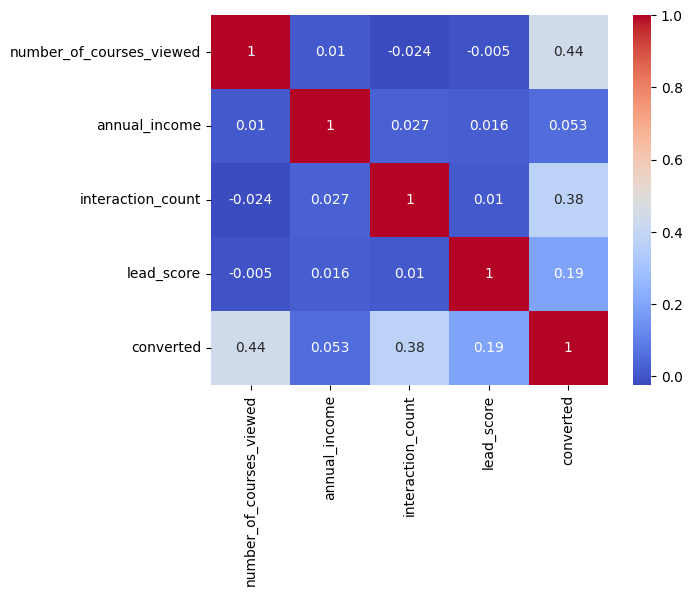

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

corr_matrix = data[numerical].corr(numeric_only = True).round(3)

sns.heatmap(corr_matrix, cmap = 'coolwarm', annot = True)

## Split the data
* Split your data into train/val/test with 60/20/20 distribution
* Use scikit-learn for that (train_test_split function) and set seed to 42
* Make sure the target value y is not in your dataframe

In [ ]:
from sklearn.model_selection import train_test_split

# Separating outcome from rest of the data
y = data['converted']
data_full = data.drop(columns='converted')

# Splitting into train set
# data_train, data_temp, y_train, y_temp = train_test_split(data_full, y, random_state=42, test_size=0.4)
# data_val, data_test, y_val, y_test = train_test_split(data_temp, y_temp, random_state=42, test_size=0.5)
## according to course material
data_full_train, data_test, y_full_train, y_test = train_test_split(data_full, y, random_state=42, test_size=0.2)
data_train, data_val, y_train, y_val = train_test_split(data_full_train, y_full_train, random_state=42, test_size=0.25)


## Question 3:
* Calculate the mutual information score between y and other categorical variables in the dataset. Use the training set only
* Round the scores to 2 decimals using

Which of these variables has the biggest mutual information score?

In [7]:
from sklearn.metrics import mutual_info_score
minfo = data_train[categorical].apply(lambda col: mutual_info_score(col, y_train).round(2))

print('The variable with the biggest mutual information score is: ', minfo[minfo == minfo.max()].index[0] )

The variable with the biggest mutual information score is:  lead_source


## Question 4:
* Now let's train a logistic regression.
* Remember that we have several categorical variables in the dataset. Include them using one-hot encoding.
* Fit the model on the training dataset.
    * To make sure the results are reproducible across different versions of scikit-learn, fit the model with these parameters:
    * model = LogisticRegression(solver='liblinear', C=1.0, max_iter =1000, random_state = 42)
* Calculate the accuracy on the validation dataset and round it to 2 decimal digits

In [8]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

dv = DictVectorizer(sparse = False)
dicts_train = data_train.to_dict(orient = 'records')
X_train = dv.fit_transform(dicts_train)

# Training the model
model = LogisticRegression(C=1.0, random_state=42, max_iter=1000, solver='liblinear')
model.fit(X_train, y_train)

# Calculate the accuracy in the validation dataset
dicts_val = data_val.to_dict(orient = 'records')
X_val = dv.transform(dicts_val)
y_val_preds = model.predict_proba(X_val)[:,1]
decision_boundary = (y_val_preds >= 0.5)
accuracy_val = (decision_boundary == y_val).mean().round(2)

print('The accuracy on the validation set is:', accuracy_val)

The accuracy on the validation set is: 0.7


## Question 5:
* Let's find the least useful feature using the feature elimination technique
* Train a model using the same features and parameters as in Q4 (without rounding)
* Now exclude each feature from this set and train a model without it. Record the accuracy for each model
* For each feature, calculate the difference between the original accuracy and the accuracy without the feature

Which of the following feature has the smallest difference?

In [12]:
# Training base model
dv = DictVectorizer(sparse = False)
dicts_train = data_train.to_dict(orient = 'records')
X_train = dv.fit_transform(dicts_train)

model = LogisticRegression(C=1.0, random_state=42, max_iter=1000, solver='liblinear')
model.fit(X_train, y_train)

# Calculate the accuracy in the validation dataset without rounding
dicts_val = data_val.to_dict(orient = 'records')
X_val = dv.transform(dicts_val)
y_val_preds = model.predict_proba(X_val)[:,1]
decision_boundary = (y_val_preds >= 0.5)
accuracy_val = (decision_boundary == y_val).mean()

features = data_train.columns
accuracy_difference = {}

for feature in features:
    data_train_drop = data_train.drop(columns = feature)
    dv_drop = DictVectorizer(sparse = False)
    dicts_train_drop = data_train_drop.to_dict(orient = 'records')
    X_train_drop = dv_drop.fit_transform(dicts_train_drop)

    model_drop = LogisticRegression(C=1.0, random_state=42, max_iter=1000, solver='liblinear')
    model_drop.fit(X_train_drop, y_train)

    # Calculate the accuracy in the validation dataset without rounding
    data_val_drop = data_val.drop(columns = feature)
    dicts_val_drop = data_val_drop.to_dict(orient = 'records')
    X_val_drop = dv_drop.transform(dicts_val_drop)
    y_val_preds_drop = model_drop.predict_proba(X_val_drop)[:,1]
    decision_boundary_drop = (y_val_preds_drop >= 0.5)
    accuracy_val_drop = (decision_boundary_drop == y_val).mean()
    accuracy_difference_drop = accuracy_val - accuracy_val_drop
    accuracy_difference['drop_' + feature] = accuracy_difference_drop

importance_rank = pd.Series(accuracy_difference).abs().sort_values()

print("The least importance features, i.e., the ones with the smallest differnce are:", 
    importance_rank[importance_rank == min(importance_rank)].index.str.removeprefix('drop_').to_list())

importance_rank


The least importance features, i.e., the ones with the smallest differnce are: ['industry']


drop_industry                    0.000000
drop_employment_status           0.003413
drop_lead_source                 0.003413
drop_lead_score                  0.006826
drop_location                    0.010239
drop_number_of_courses_viewed    0.143345
drop_interaction_count           0.143345
drop_annual_income               0.153584
dtype: float64

## Question 6
* Now let's train a regularized logistic regression.
* Let's try the following values of the parameter C: [0.01, 0.1, 1, 10, 100]
* Train models using all the features as in Q4
* Calculate the accuracy on the validation dataset and round it to 3 decimal digits

Which of these C leads to the best accuracy on the validation set?

In [11]:
dv = DictVectorizer(sparse = False)
dicts_train = data_train.to_dict(orient = 'records')
X_train = dv.fit_transform(dicts_train)
regularization = [0.01, 0.1, 1, 10, 100]
accuracy_reg = []

for reg in regularization:
    model = LogisticRegression(C=reg, random_state=42, max_iter=1000, solver='liblinear')
    model.fit(X_train, y_train)

    # Calculate the accuracy in the validation dataset
    dicts_val = data_val.to_dict(orient = 'records')
    X_val = dv.transform(dicts_val)
    y_val_preds = model.predict_proba(X_val)[:,1]
    decision_boundary = (y_val_preds >= 0.5)
    accuracy_val = (decision_boundary == y_val).mean().round(3)
    accuracy_reg.append(accuracy_val)
    print(f"C = {reg}, accuracy = {accuracy_val}")

C = 0.01, accuracy = 0.7
C = 0.1, accuracy = 0.7
C = 1, accuracy = 0.7
C = 10, accuracy = 0.7
C = 100, accuracy = 0.7
